# Network Intrusion Detection Classifier using Support Vector Machine

Imports and Data Preparation


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
from tqdm import tqdm
import os

# URLs for NSL-KDD dataset
train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(train_file):
    print("Downloading training dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset...")
    urlretrieve(test_url, test_file)

NSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]


train_df = pd.read_csv(train_file, names=NSL_columns, header=None)
test_df = pd.read_csv(test_file, names=NSL_columns, header=None)


# Preprocessing data (Label encoding for categorical columns and convert class labels to binary (0 for normal, 1 for attack)]
df = pd.concat([train_df, test_df], axis=0)

categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df["class"] = df["class"].apply(lambda x: 0 if x == "normal" else 1)

X = df.drop("class", axis=1).values
y = df["class"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train = X[:len(train_df)]
y_train = y[:len(train_df)]
X_test = X[len(train_df):]
y_test = y[len(train_df):]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


Training set: 125973 samples
Testing set: 22544 samples


SVM Classifier Implementation

In [2]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, epochs=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.epochs), desc="Training Progress"):
            for idx, x_i in enumerate(X):
            # Margin condition: if the sample is correctly classified and outside the margin
                cndn = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1

                if cndn:
                # Apply L2 regularization if correctly classified and outside margin
                  self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                  # Else if it is within margin or misclassified, update both weights and bias
                  # (gradient step considers hinge loss and regularization)
                  self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                  self.b -= self.lr * y_[idx]  # Adjusting bias


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(approx >= 0, 1, 0)


Training and Evaluating the SVM Model

Training Progress: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


SVM Model Accuracy: 85.63%
Precision: 0.9298
Recall: 0.8087
F1-score: 0.8650
Confusion Matrix:


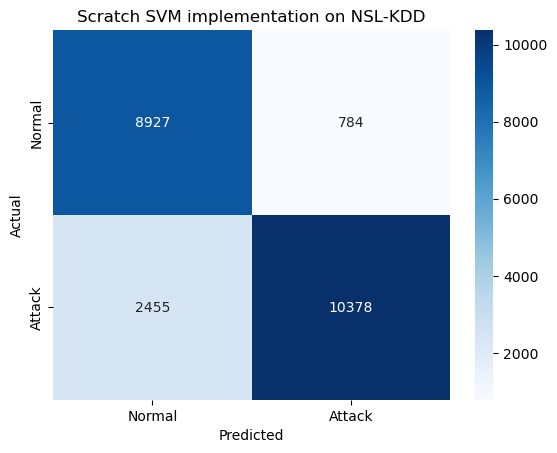

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train SVM model
svm_classifier = SVM(learning_rate=0.001, lambda_param=0.01, epochs=10)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100
print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Scratch SVM implementation on NSL-KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()

Scikit learn SVM implementation

Scikit-learn SVM Accuracy: 84.67%
Precision: 0.9264
Recall: 0.7937
F1-score: 0.8550
Confusion Matrix:


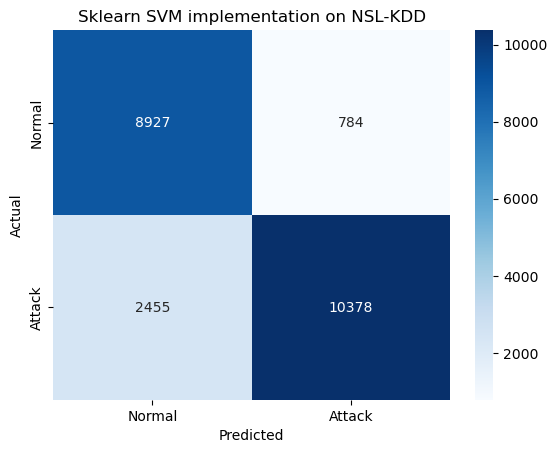

In [4]:
from sklearn.svm import SVC

svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)

accuracy_sklearn = np.mean(y_pred_sklearn == y_test) * 100
print(f"Scikit-learn SVM Accuracy: {accuracy_sklearn:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_sklearn)
recall_svm = recall_score(y_test, y_pred_sklearn)
f1_svm = f1_score(y_test, y_pred_sklearn)
conf_matrix_svm = confusion_matrix(y_test, y_pred_sklearn)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Sklearn SVM implementation on NSL-KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()


a) KDD-Cup'99

In [5]:
# (a) KDD Cup '99

url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

#defining columns 
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
df = df.drop_duplicates()  

print(df.shape)


(145586, 42)


In [6]:
print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 
#Clearly, we can see that this daataset is very skewed and imbalanced

{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [7]:
#Preprocessing Data

# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 80% train, 20% test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training Progress: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


SVM Model Accuracy: 98.14%
Precision: 0.9949
Recall: 0.9579
F1-score: 0.9760
Confusion Matrix:


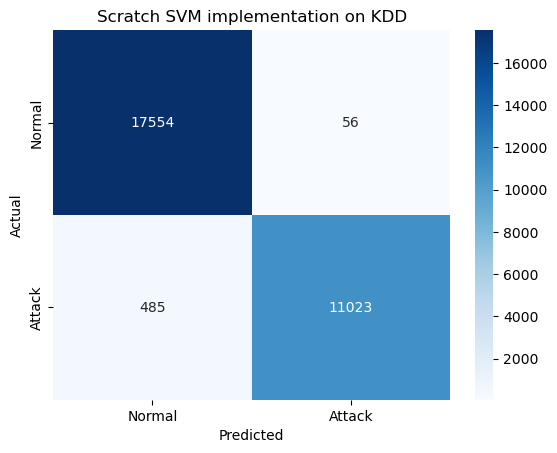

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train SVM model
svm_classifier = SVM(learning_rate=0.001, lambda_param=0.01, epochs=10)
svm_classifier.fit(X_train, y_train)

# Predict and check accuracy on test data
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = np.mean(y_pred_svm == y_test) * 100
print(f"SVM Model Accuracy: {accuracy_svm:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Scratch SVM implementation on KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()

Scikit-learn SVM Accuracy: 99.07%
Precision: 0.9884
Recall: 0.9880
F1-score: 0.9882
Confusion Matrix:


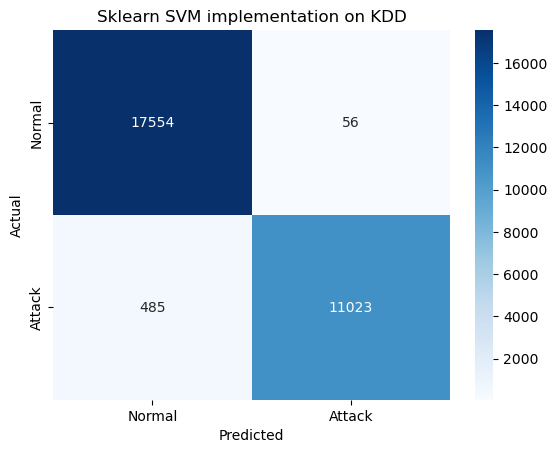

In [9]:
from sklearn.svm import SVC

svm_sklearn = SVC(kernel='linear')
svm_sklearn.fit(X_train, y_train)
y_pred_sklearn = svm_sklearn.predict(X_test)

accuracy_sklearn = np.mean(y_pred_sklearn == y_test) * 100
print(f"Scikit-learn SVM Accuracy: {accuracy_sklearn:.2f}%")

# Evaluate performance metrics
precision_svm = precision_score(y_test, y_pred_sklearn)
recall_svm = recall_score(y_test, y_pred_sklearn)
f1_svm = f1_score(y_test, y_pred_sklearn)
conf_matrix_svm = confusion_matrix(y_test, y_pred_sklearn)

# Print results
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
title='Sklearn SVM implementation on KDD'
#plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(title)
plt.show()
